In [2]:
import os
import random
import time

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from captum.attr import *
from tqdm.auto import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from pydictobject import DictObject

from BERTweet.TweetNormalizer import *

# Ensure deterministic behavior
seed = 12345678
seed = 87654321

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

cuda:0


In [3]:
model = AutoModelForSequenceClassification.from_pretrained("results_sentiment140/model_13")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large", use_fast=False)
model.eval()
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [4]:
# df = pd.read_csv("sentiment.csv")
df = pd.read_csv("data/sentiment140.csv", names=["target", "id", "date", "flag", "user", "tweet"], encoding="ISO-8859-1")

In [5]:
len(df)

1600000

In [6]:
scores = []
open("pred.csv", "w").close()

In [7]:
with open("pred.csv", "r") as f:
    scores = [[float(x) for x in line.strip().split()] for line in f.readlines()]

In [8]:
print(len(scores))
print(len(df))

0
1600000


In [9]:
batch_size = 256

with torch.no_grad():
    for i in tqdm(range(len(scores)//batch_size, len(df), batch_size)):
        tweets = df["tweet"][i:min(i+batch_size, len(df))].values
        batch = tokenizer(normalizeTweet(tweets), padding=True, max_length=512, truncation=True, return_tensors='pt')["input_ids"]
        batch = batch.to(device)

        output = model(batch).logits.tolist()

        scores.extend(output)

        with open("pred.csv", "a") as f:
            for i in output:
                f.write(f"{i[0]} {i[1]}\n")

  0%|          | 0/6250 [00:00<?, ?it/s]

In [29]:
# df = pd.read_csv("sentiment.csv")
df = pd.read_csv("data/sentiment140.csv", names=["sentiment_score", "id", "date", "flag", "user", "tweet"], encoding="ISO-8859-1")

In [30]:
with open("pred.csv", "r") as f:
    scores = [[float(x) for x in l.split()] for l in f.readlines()]

In [31]:
pred = torch.softmax(torch.tensor(scores), dim=-1)
label = torch.argmax(torch.tensor(scores), dim=-1)

df["pred"] = pred[:,1]
df["label"] = label

<Axes: ylabel='Frequency'>

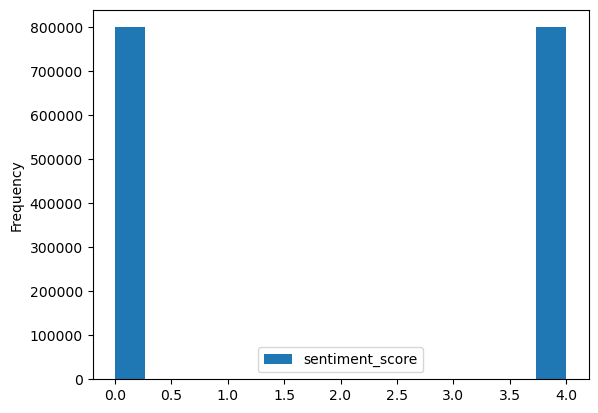

In [24]:
df.plot.hist(column="sentiment_score", bins=15, range=[0, 4])

<Axes: ylabel='Frequency'>

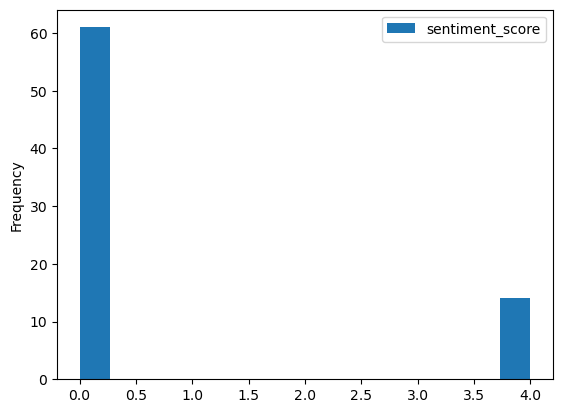

In [33]:
df[df["label"]==1].plot.hist(column="sentiment_score", bins=15, range=[0, 4])

<Axes: ylabel='Frequency'>

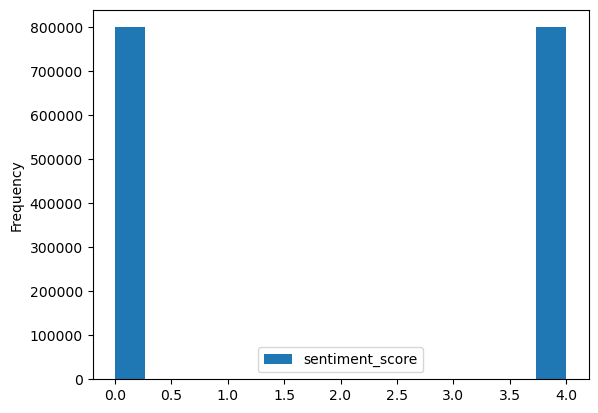

In [34]:
df[df["label"]==0].plot.hist(column="sentiment_score", bins=15, range=[0, 4])

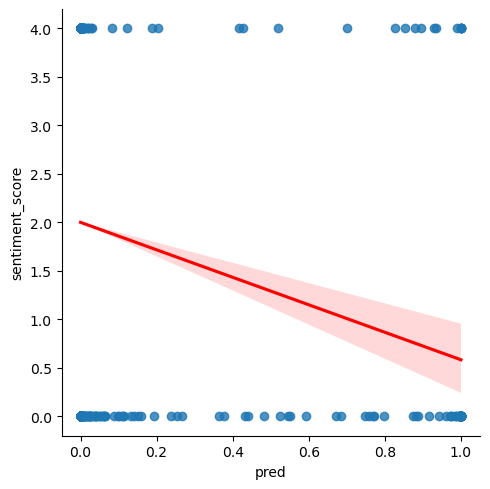

In [35]:
sns.lmplot(
    data=df,
    x="pred",
    y="sentiment_score",
    line_kws={'color': 'red'}
)